Christiaan van Roon - 11122854  
Sander Hansen - 10995080

# Histogram of Oriented Gradients

In [1]:
#Pylab inline is not a good habit to use
import numpy
import matplotlib

from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *


Step 1: Preprocessing
---------------------

I couldn't find the bolt.png image that is used but i found the
bolt2.png image.

Crop the outline of one of the runners as is done in the webarticle
(i.e. in a 1:2 aspect ratio!) and warp (resize) it to a size of 64x128
pixels (colums x rows). Like in the article you should select a rather
large border around the running figure.

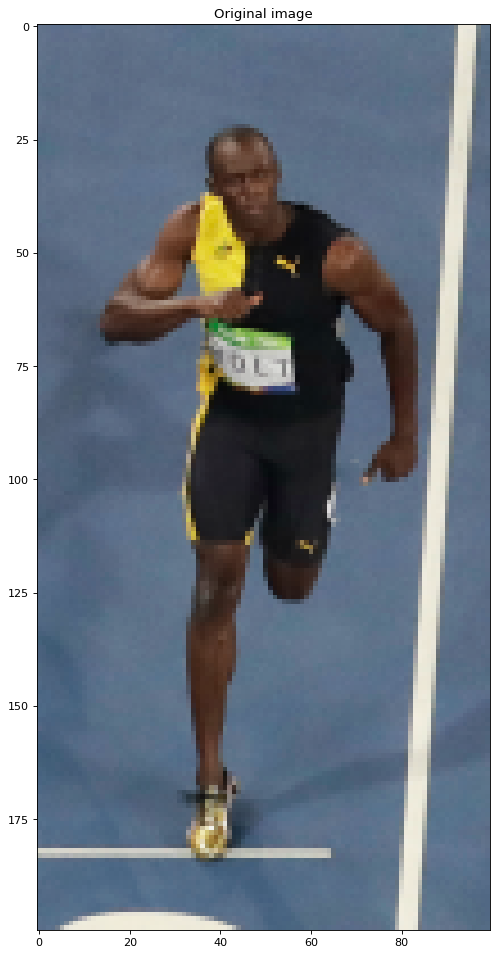

In [2]:
plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w')

image = imread('img/bolt.png')[100:300, 205:305]
plt.imshow(image)
plt.title('Original image')
plt.show()

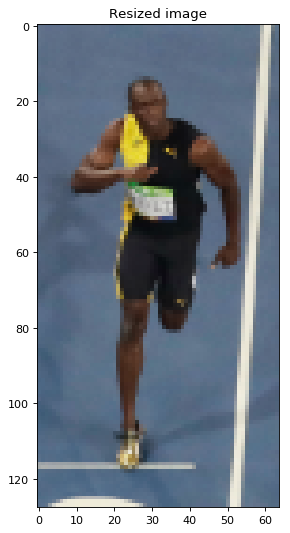

In [3]:
import skimage.transform

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w')

image = skimage.transform.resize(image,(128, 64), mode='reflect')
plt.imshow(image)
plt.title('Resized image')
plt.show()

Step 2: Calculate the Gradient Images
-------------------------------------

We can do better than just using simple central difference schemes as
used in the web article. Calculate the gradient using Gaussian
derivatives (at a small scale).

There is one snag in this. The OpenCV code deals with color images in
a rather peculiar way. It calculates the derivatives for each color
channel separately. Combination of the color channels to come up with
one gradient magnitude and one gradient angle is not defined clearly
(imho).

We make a shortcut here. **We first reduce the color image to a gray
value image. And use this scalar image from here on.**

Visualize the gradient components $f_x$ and $f_y$ and the gradient
magnitude.

Write a simple function `mag, angle = cart2polar(fx, fy)`. In the web
article the angle is in degrees. I strongly suggest you do all your
programming with angles in radians. Make sure that the angle that is
returned is an **orientation angle** in the range from $0$ to $\pi$. 

*To calculate the gradients in horizontal and vertical direction, we apply the following filters to the image:*
   *$$\pmatrix{-1&0&1}$$ for the horizontal gradient and* 
   *$$\pmatrix{-1\\0\\1}$$ for the vertical gradient. See code below for the implementation.*



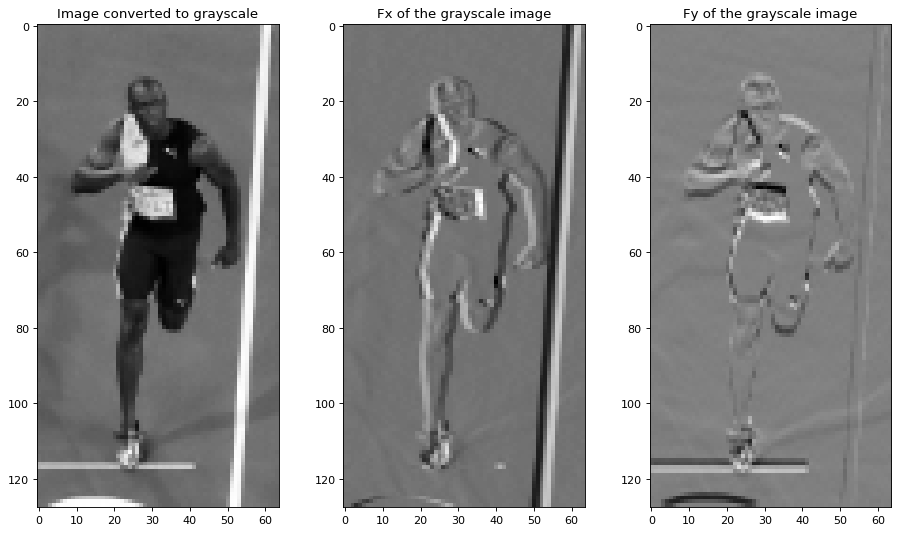

In [4]:
import skimage.color
import scipy

#Convert image to grayscale
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w')
gray_image = skimage.color.rgb2gray(image)

plt.subplot(1,3,1)
plt.imshow(gray_image, cmap= cm.gray)
plt.title('Image converted to grayscale')

#Apply filter for the horizontal gradient (Fx)
fx = scipy.ndimage.filters.convolve(gray_image, [[0,0,0],[-1, 0, 1], [0,0,0]])
plt.subplot(1,3,2)
plt.title('Fx of the grayscale image')
plt.imshow(fx, cmap=cm.gray)

#Apply filter for the vertical gradient (Fy)
fy = scipy.ndimage.filters.convolve(gray_image, [[0,-1,0],[0, 0, 0], [0,1,0]])
plt.subplot(1,3,3)
plt.title('Fy of the grayscale image')
plt.imshow(fy, cmap=cm.gray)

plt.show()

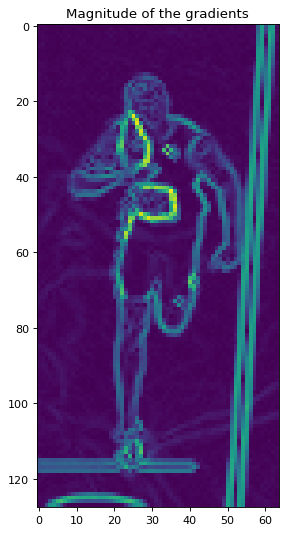

In [5]:
def cart2pol(fx, fy):
    """
    Function returns a magnitude and a angle. The magnitude describes a sharp change in color intensity and
        the angle describes the direction of the gradient.
    """
    g = sqrt(fx**2 + fy**2)
    theta = arctan(fy / fx)
    theta[theta < 0] += pi
    return g, theta

#Plot the magnitude of gradients of our image.
mag, rad = cart2pol(fx,fy) 
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w')

plt.subplot(1,2,1)
plt.imshow(mag)
plt.title('Magnitude of the gradients')
plt.show()

Step 3: Calculate HOG in 8x8 Cells
----------------------------------

Write a function `HOG8x8(gx, gy)` that takes two a scalar 8x8 images as
input where gx is the derivative in x direction and gy the derivative
in y direction. The function should return a 9 bin histogram (as a
vector of shape (9,)) as explained in the web article.

Note that the `histogram` function from numpy has a keyword argument
`weights` and that is just what is needed in this application!

Test your function before moving on::

  gx = ones((8,8)) $\times$ cos(pi/4)  
  gy = ones((8,8)) $\times$ sin(pi/4)  
  h = HOG8x8(gx, gy)

What would you expect to be the result histogram `h` for different
angles (instead of `pi/4`)?

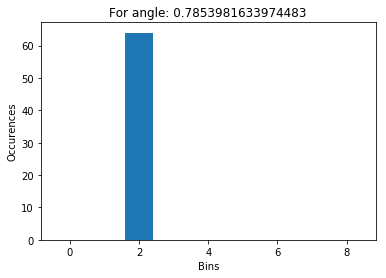

[  0.   0.  64.   0.   0.   0.   0.   0.   0.]


In [6]:
def HOG8x8(gx, gy):
    """
    Create a histogram of the angles of the gradients and where the magnitude is used as weight
    """
    mag, rad = cart2pol(gx, gy)
    return histogram(rad ,bins=9, range=(0, pi), weights=mag)[0]

angle = pi / 4
gx = ones((8,8)) * cos(angle)
gy = ones((8,8)) * sin(angle)
plt.bar(range(len(HOG8x8(gx,gy))), HOG8x8(gx,gy))
plt.xlabel('Bins')
plt.ylabel('Occurences')
plt.title('For angle: ' + str(angle))
plt.show()
print(HOG8x8(gx,gy))

As you can see one bin is completely filled due to the identical values spread across the image.
When you take another angle you could expect another bin to be filled. Say you take an angle of pi / 2, then you can expect the middle bin to be completely filled, as the 0 to 9 scaling represents the 0 to pi scaling.

Step 4: Block Normalization
---------------------------

In step 4 it is only explained how normalization works. It is used in step 5.

Step 5: Calculate the HOG feature vector
----------------------------------------

Write a function `HOGblock(h1, h2, h3, h4)` that takes 4 cell
histograms from step 3, concatenates them in one large (36,) vector
and normalizes the vector.

Use this function to calculate the block histograms for all 7x15
blocks as explained in the text and concatenate those.

If all went well you end up with a giant vector of 3780 entries (shape
is (3780,)).

In [7]:
def HOGblock(h1, h2, h3, h4):
    """
    Concatenate the HOGs of 4 8x8 blocks into one vector and normalize it.
    """
    h = append(h1 ,h2)
    h = append(h, h3)
    h = append(h, h4)
    return h / norm(h)

def HOGimage(gx, gy):
    """
    Create a large HOG feature vector of all separate blocks of the image
    """
    #Peform a reshape so you can easily extract the blocks from the two gradients
    xblocks = gx.reshape(16, 8, -1, 8).swapaxes(1,2).reshape(-1, 8, 8)
    yblocks = gy.reshape(16, 8, -1, 8).swapaxes(1,2).reshape(-1, 8, 8)
    
    feature_vector = []
    #Get 105 blocks of 16 x 16
    for i in range(0, 15):
        for j in range(0, 7):
            #Get the current block (i * 8 + j) the next one on the same row (i * 8e+ j + 1)
            # the one on the next row but the same column ((i + 1) * 8 + j) and the
            # one on the next row and column (i + 1) * 8 + j + 1
            h1 = HOG8x8(xblocks[i * 8 + j], yblocks[i * 8 + j])
            h2 = HOG8x8(xblocks[i * 8 + j + 1], yblocks[i * 8 + j + 1])
            h3 = HOG8x8(xblocks[(i + 1) * 8 + j], yblocks[(i + 1) * 8 + j])
            h4 = HOG8x8(xblocks[(i + 1) * 8 + j + 1], yblocks[i * 8 + j + 1])
            
            # Concatenate the HOG of the 16x16 blocks 
            feature_vector = append(feature_vector, HOGblock(h1,h2,h3,h4))
            
    return feature_vector

#To check if the resulting vector is the right shape
feature_vector = HOGimage(fx, fy)
print("Shape of the feature vector: " + str(shape(feature_vector)))

Shape of the feature vector: (3780,)


Step 6: Visualizing the HOG
---------------------------

Hah, now we can do better... Using matplotlib we can plot graphics on
top of an image. The visualization that is shown in the webarticle is
simple. In the middle of each 8x8 block we draw a "rose of
directions": every bin in the histogram for that block shows the
strength of the gradient in that particular orientation. We draw a
line in the orientation (center of the line in the middle of the
block) with a length that is proportional to the bin count in the
histogram. In our case that is 9 lines for each of the bins.

In doing so you have to consider:

1. What the lengths should be? They should be proportional to the bin
   count but it should be a visually pleasing result.  
*The lengths should be scaled with pi. Every bin belongs to pi / 9 and thus if a bin has a higher value it should get a longer arrow.*


2. You should realize that one 8x8 block is represented several times
   in the large vector. But the histograms belonging to one block are
   not the same. Why not? How would you deal with that?  
*Every 8x8 block is atleast 2 times represented in the large vector. Not every histogram is the same because of the way we normalize the histograms. We normalize over a full 16x16 block and thus is the result dependent on the values of adjacent histograms. To prevent a weird result you should just pick one block out of every 16x16 block, and this should every time be the same position, so for example the upper-left block. This way you only use every histogram once.*   


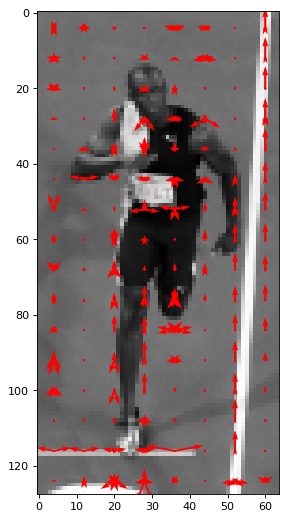

In [8]:
#Plot normal grayscale image
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w')
plt.imshow(gray_image, cmap=cm.gray)

#Loop over all the blocks and plot 9 arrows for every block
for i in range(16):
    for j in range(8):
        
        #When we reach an edge block we need to skip extra pieces
        if j == 7:
            if i == 15:
                index = (j - 1  + i -1 * 7)* 36 + 27
            else:
                index = (j-1 + i * 7) * 36 + 9    
        
        elif i == 15:
            index = (j + i -1 * 7) * 36 + 18
        
        else:
            index = (j + i * 7) * 36
        
        #Get the block and create an array of length 9, for every arrow(bin!) an entry
        block = feature_vector[index: index + 9]
        arrow_points = np.arange(9)
        
        xmid_block = j*8 + 4
        ymid_block = i*8 + 4
        
        #Scalars for the direction of the arrows
        xscalar = sin(arrow_points / 9 * pi)
        yscalar = cos(arrow_points / 9 * pi)
        
        #Plot in both positive and negative direction
        plt.quiver(xmid_block, ymid_block, block * xscalar , block * yscalar, color='red', scale=8)
        plt.quiver(xmid_block, ymid_block, -block * xscalar, block * yscalar, color='red', scale=8)
        
plt.show()


Step 7: And Beyond
---------------------------

Histogram of Oriented Gradients are often used in computer vision
practice as the descriptor for objects in images. You can detect
faces, cars, license plates, traffic signs, birds, etc etc in images
using HOG's.

The machine learning architecture of such a system is more or less
trivial. The HOG descriptor (in our case above the 3780 element
vector) serves as the feature vector in any machine learning
classification scheme (SVM, NN, Logistic Regression). Obviously you
need quit a lot of examples, that means that you have to annotate a
lot of images.

In practice it is a bit harder to use a HOG based detector as in
reality it is seldomly the case that the position and size of the
object in the image is known a priori. You have to scan the entire
image at all possible sizes and for each subimage classify the
resulting HOG. Dealing with this is not trivial on its own.